# CVAT Labeling Workflow

End-to-end workflow for refining ensemble predictions in CVAT.

**Steps:**
1. Download the dataset from HuggingFace
2. Get your assigned tiles
3. Install CVAT and import images + annotations
4. Fix the labels in CVAT
5. Export corrected labels
6. Upload corrected labels back to HuggingFace

**6 Ensemble Classes:**

| Class | Label | Color |
|-------|-------|-------|
| 0 | background | gray |
| 1 | building | red |
| 2 | woodland | dark green |
| 3 | water | blue |
| 4 | road | yellow |
| 5 | mangrove | bright green |

In [1]:
import os
import shutil
import zipfile
import tempfile
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from huggingface_hub import snapshot_download, HfApi, upload_folder

In [2]:
# ============================================================
# CONFIGURATION — edit these
# ============================================================

USERNAME = "choshingcheung"  # your name (used for upload folder)
START_IDX = 0       # first tile index (inclusive)
END_IDX = 10       # last tile index (exclusive)

HF_REPO = "e4e-mangrove-monitoring/E4E_Mangrove_Ensemble_CVAT"

In [3]:
# ============================================================
# Fixed config
# ============================================================

WORK_DIR = Path("labeling_workspace")
MY_IMAGES_DIR = WORK_DIR / "my_images"
MY_ANNOTATIONS_ZIP = WORK_DIR / "my_annotations.zip"
CORRECTED_DIR = WORK_DIR / "corrected_masks"

CLASS_NAMES = ['background', 'building', 'woodland', 'water', 'road', 'mangrove']
CLASS_COLORS = {
    0: (204, 204, 204),
    1: (255, 0, 0),
    2: (0, 128, 0),
    3: (0, 0, 255),
    4: (255, 255, 0),
    5: (0, 230, 102),
}

WORK_DIR.mkdir(parents=True, exist_ok=True)
print(f"User: {USERNAME}")
print(f"Tiles: {START_IDX} to {END_IDX}")
print(f"Workspace: {WORK_DIR}")

User: choshingcheung
Tiles: 0 to 10
Workspace: labeling_workspace


## Step 1 — Download dataset from HuggingFace

In [4]:
dataset_dir = snapshot_download(
    repo_id=HF_REPO,
    repo_type="dataset",
    local_dir=WORK_DIR / "hf_download",
)
dataset_dir = Path(dataset_dir)

hf_images_dir = dataset_dir / "images"
hf_zip_path = dataset_dir / "cvat_ensemble_masks.zip"

all_tiles = sorted(hf_images_dir.glob("*.png"))
print(f"Downloaded {len(all_tiles)} tiles")
print(f"Annotation ZIP: {hf_zip_path}")

Fetching 575 files:   0%|          | 0/575 [00:00<?, ?it/s]

Downloaded 573 tiles
Annotation ZIP: C:\vscode workspace\ml-mangrove\DroneClassification\model_assisted_labeling\labeling_workspace\hf_download\cvat_ensemble_masks.zip


## Step 2 — Get your assigned tiles

In [5]:
# Copy assigned tile images
MY_IMAGES_DIR.mkdir(parents=True, exist_ok=True)

my_tiles = all_tiles[START_IDX:END_IDX]
my_tile_names = set()

for tile_path in my_tiles:
    shutil.copy2(tile_path, MY_IMAGES_DIR / tile_path.name)
    my_tile_names.add(tile_path.stem)  # e.g. 'tile_00042'

print(f"Copied {len(my_tiles)} images to {MY_IMAGES_DIR}")

# Extract only assigned masks from the full ZIP, re-package into a smaller ZIP
with tempfile.TemporaryDirectory() as tmp:
    tmp_path = Path(tmp)

    seg_class_dir = tmp_path / "SegmentationClass"
    seg_obj_dir = tmp_path / "SegmentationObject"
    imageset_dir = tmp_path / "ImageSets" / "Segmentation"

    seg_class_dir.mkdir(parents=True)
    seg_obj_dir.mkdir(parents=True)
    imageset_dir.mkdir(parents=True)

    # Extract matching masks from full zip
    with zipfile.ZipFile(hf_zip_path, 'r') as zf:
        for entry in zf.namelist():
            entry_stem = Path(entry).stem
            if entry_stem in my_tile_names:
                if "SegmentationClass/" in entry:
                    data = zf.read(entry)
                    (seg_class_dir / Path(entry).name).write_bytes(data)
                    (seg_obj_dir / Path(entry).name).write_bytes(data)

    # labelmap.txt
    with open(tmp_path / "labelmap.txt", 'w') as f:
        for class_id, class_name in enumerate(CLASS_NAMES):
            r, g, b = CLASS_COLORS[class_id]
            f.write(f"{class_name}:{r},{g},{b}::\n")

    # default.txt
    with open(imageset_dir / "default.txt", 'w') as f:
        for name in sorted(my_tile_names):
            f.write(name + '\n')

    # Create zip
    with zipfile.ZipFile(MY_ANNOTATIONS_ZIP, 'w', zipfile.ZIP_DEFLATED) as zf:
        for root, dirs, files in os.walk(tmp_path):
            for file in files:
                file_path = Path(root) / file
                zf.write(file_path, file_path.relative_to(tmp_path))

print(f"Created {MY_ANNOTATIONS_ZIP} ({MY_ANNOTATIONS_ZIP.stat().st_size / 1024:.0f} KB)")
print(f"\nReady for CVAT:")
print(f"  Images: {MY_IMAGES_DIR}")
print(f"  Annotations: {MY_ANNOTATIONS_ZIP}")

Copied 10 images to labeling_workspace\my_images
Created labeling_workspace\my_annotations.zip (156 KB)

Ready for CVAT:
  Images: labeling_workspace\my_images
  Annotations: labeling_workspace\my_annotations.zip


## Steps 3 & 4 — CVAT: Import, label, export

### Install CVAT (one-time)
## Step 1: Install Git for Windows

1. Download Git for Windows from [https://gitforwindows.org/](https://gitforwindows.org/).
2. Install Git, keeping all options as default.
3. Open the command prompt (`cmd`) and type the following command to check the Git version:
    ```bash
    git --version
    ```

## Step 2: Install Docker Desktop for Windows

1. Download [Docker Desktop for Windows](https://desktop.docker.com/win/main/amd64/Docker%20Desktop%20Installer.exe).
2. Double-click the Docker for Windows Installer to run the installer.
3. Follow the instructions for installation, and reboot the system after installation is complete.
4. Open the command prompt and check the Docker version:
    ```bash
    docker --version
    ```
5. Check the Docker Compose version:
    ```bash
    docker compose version
    ```

## Step 3: Install Google Chrome

1. Download and install [Google Chrome](https://www.google.com/chrome/), as it is the only browser supported by CVAT.

## Step 4: Clone CVAT Source Code

1. Clone CVAT source code from the [GitHub repository](https://github.com/opencv/cvat):
    ```bash
    git clone https://github.com/opencv/cvat
    cd cvat
    ```
2. Alternatively, check [alternatives](https://opencv.github.io/cvat/docs/administration/basics/installation/#how-to-get-cvat-source-code) for downloading specific release versions.

## Step 5: Run Docker Containers for CVAT

1. Run the following command to start Docker containers. This will download the latest CVAT release and other required images:
    ```bash
    docker compose up -d
    ```
2. Optionally, specify the CVAT version using the CVAT_VERSION environment variable:
    ```bash
    CVAT_VERSION=dev docker compose up -d
    ```
3. Check the status of the containers:
    ```bash
    docker ps
    ```
4. Wait until the CVAT server is up and running:
    ```bash
    docker logs cvat_server -f
    ```
5. Run the CVAT server:
    ```bash
    docker exec -it cvat_server bash
    ```
6. For the first-time setup, create a superuser account:
    ```bash
    python3 manage.py createsuperuser
    ```
    Choose a username and password for the admin account.

## Step 6: Access CVAT in Google Chrome

1. Open Google Chrome and go to `localhost:8080`.
2. Log in with the superuser credentials created earlier.
3. You should now be able to create a new annotation task.

## Workflow
To stop and remove the container, simply type, 
```bash
docker compose down
```
And to start cvat again, simply type 
```bash
docker compose up -d
```
Make sure you're in the correct directory

### Import & label
1. **Create project** with labels: `background`, `building`, `woodland`, `water`, `road`, `mangrove`
2. **Create task** → upload images from `labeling_workspace/my_images/`
3. **Import annotations** → Menu → Upload annotations → **Segmentation mask 1.1** → upload `labeling_workspace/my_annotations.zip`
4. **Refine labels** using brush/eraser tools
5. **Export** → Menu → Export task dataset → **Segmentation mask 1.1** → download ZIP

## Step 5 — Import corrected masks from CVAT export

Extracted 10 corrected masks to labeling_workspace\corrected_masks


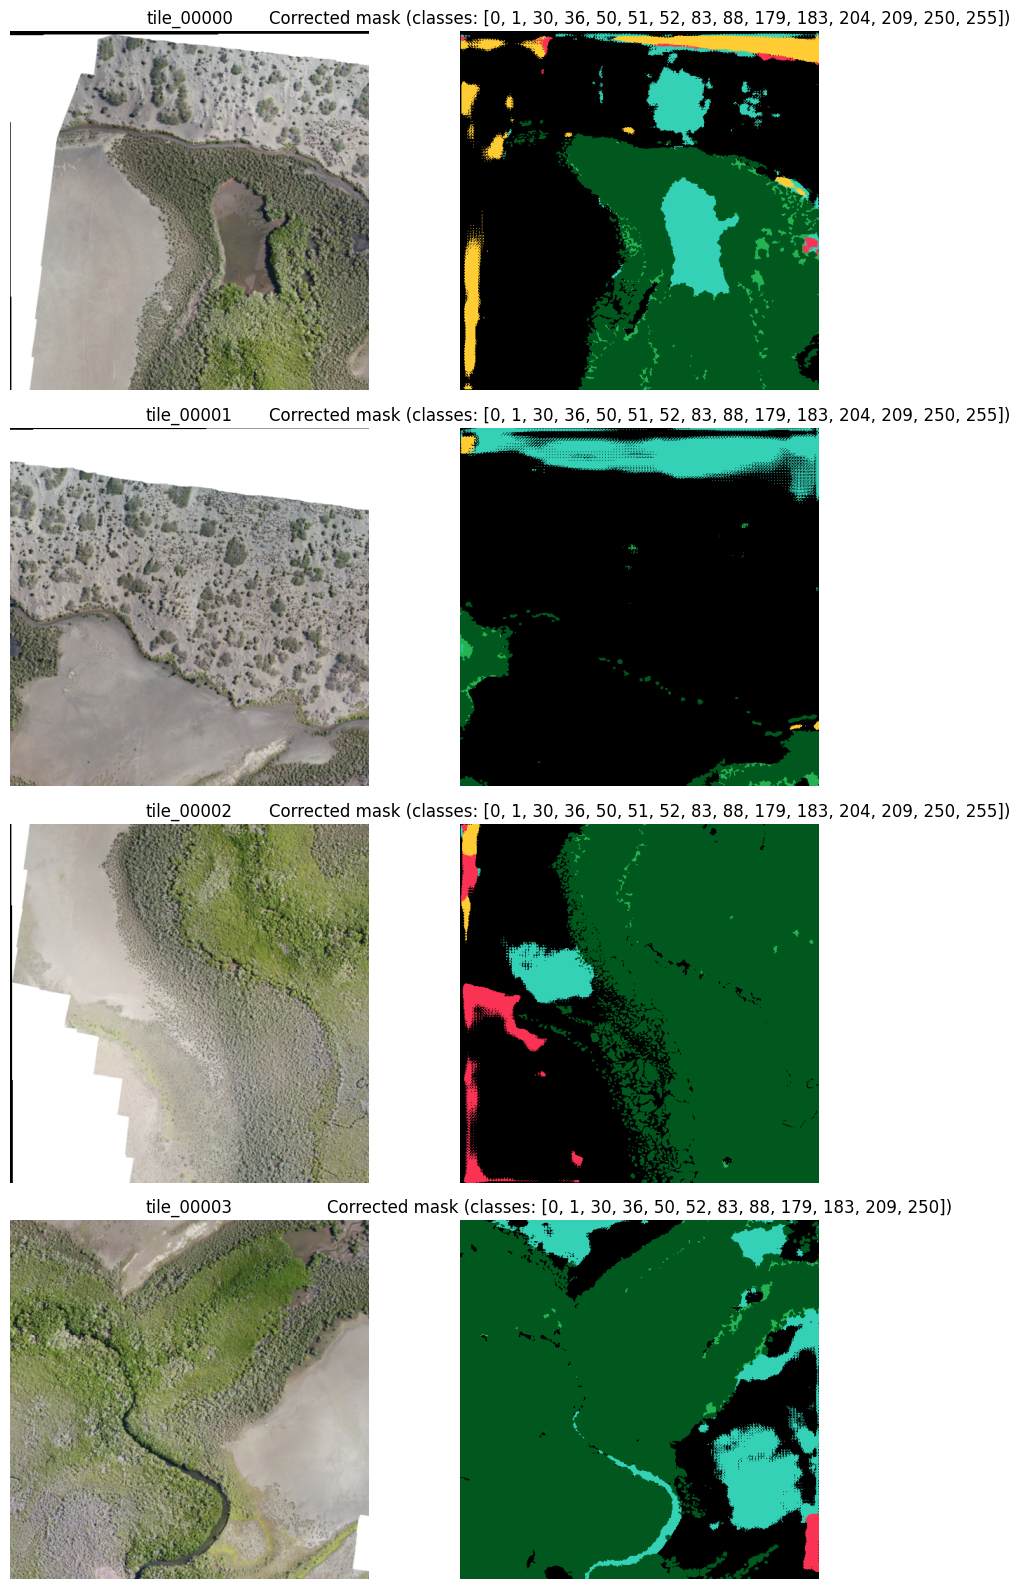

In [6]:
# ===== Point this to your downloaded CVAT export ZIP =====
CVAT_EXPORT_ZIP = Path("labeling_workspace/exported_from_cvat.zip")  # update this path
# =========================================================

CORRECTED_DIR.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(CVAT_EXPORT_ZIP, 'r') as zf:
    for entry in zf.namelist():
        if "SegmentationClass/" in entry and entry.endswith(".png"):
            data = zf.read(entry)
            out_path = CORRECTED_DIR / Path(entry).name
            out_path.write_bytes(data)

corrected_files = sorted(CORRECTED_DIR.glob("*.png"))
print(f"Extracted {len(corrected_files)} corrected masks to {CORRECTED_DIR}")

# Sanity check: show a few samples
n_show = min(4, len(corrected_files))
fig, axes = plt.subplots(n_show, 2, figsize=(10, 4 * n_show))
if n_show == 1:
    axes = axes[np.newaxis, :]

for i in range(n_show):
    mask_path = corrected_files[i]
    img_path = MY_IMAGES_DIR / mask_path.name

    mask = np.array(Image.open(mask_path))
    if img_path.exists():
        img = np.array(Image.open(img_path))
        axes[i, 0].imshow(img)
    axes[i, 0].set_title(mask_path.stem)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask, vmin=0, vmax=5, cmap='tab10')
    axes[i, 1].set_title(f'Corrected mask (classes: {np.unique(mask).tolist()})')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## Step 6 — Upload corrected labels back to HuggingFace

In [7]:
upload_folder(
    folder_path=str(CORRECTED_DIR),
    path_in_repo=f"corrected/{USERNAME}",
    repo_id=HF_REPO,
    repo_type="dataset",
)
print(f"Uploaded corrected masks to {HF_REPO}/corrected/{USERNAME}/")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploaded corrected masks to e4e-mangrove-monitoring/E4E_Mangrove_Ensemble_CVAT/corrected/choshingcheung/
